# Implementar o Info DCGAN

In [1]:
# import struct
# import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
# from torch.autograd import Variable
from torch import nn
from  torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# import argparse
import os
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
dataroot = "/home/ninja/MNIST/training/"        # Root directory for dataset
workers = 4                    # Number of workers for dataloader
batch_size = 256               # Batch size during training
image_size = 64
ngpu = 1                       # Number of GPUs available. Use 0 for CPU mode.

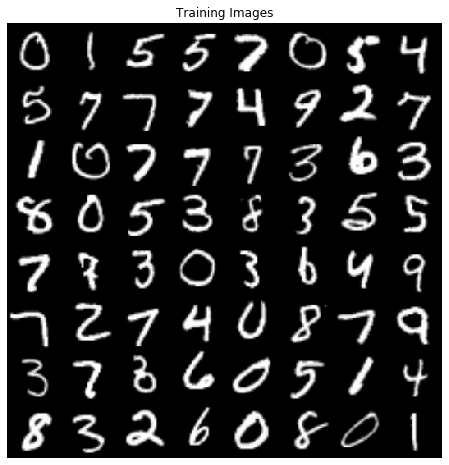

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = Data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

---
* Funções de auxílio

---

![](images/dcgan_generator.png)

In [7]:
nc = 3                         # Number of channels in the training images. For color images this is 3
nz = 100                       # Size of z latent vector (i.e. size of generator input)
ngf = 64                       # Size of feature maps in generator
ndf = 64   

# Generator
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            torch.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Tanh())

    def forward(self, z):
        return self.main(z)

# Discriminator   
class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class QNet(nn.Module):
    def __init__(self,ngpu):
        super(QNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Linear(ndf * 8, 1)
            torch.nn.Sigmoid()
            


    def forward(self, x):
        return self.main(x)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G = GNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
G.apply(weights_init)
D = DNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
D.apply(weights_init)
Q = QNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Q = nn.DataParallel(Q, list(range(ngpu)))
Q.apply(weights_init)

num_epochs = 10                 # Number of training epochs
lr = 0.002                     # Learning rate for optimizers
beta = 0.5                    # Beta1 hyperparam for Adam optimizers

# Definimos os otimizadores
G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta,0.999))
Q_optim = optim.Adam(Q.parameters(), lr=lr, betas=(beta,0.999))

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

loss = torch.nn.BCELoss()
# Loss for discrete latent code.
Q_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
# criterionQ_con = NormalNLLLoss()
real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [8]:
%%time

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # D network: maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        X = data[0].to(device)
        X_size = X.size(0)
        ones = torch.full((X_size,), real_label, device=device)
        X_real_out = D(X).view(-1)
        D_loss_real = loss(X_real_out, ones)
        D_loss_real.backward()
        D_loss_real_mean = X_real_out.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(X_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        X_fake = G(noise)
        zeros = torch.full((X_size,), fake_label, device=device)
        # Classify all fake batch with D
        X_fake_out = D(X_fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        D_loss_fake = loss(X_fake_out, zeros)
        # Calculate the gradients for this batch
        D_loss_fake.backward()
        D_loss_fake_mean_1 = X_fake_out.mean().item()
        # Add the gradients from the all-real and all-fake batches
        D_loss = D_loss_real + D_loss_fake
        # Update D
        D_optim.step()

        # G network: maximize log(D(G(z)))
        G.zero_grad()
        ones = torch.full((X_size,), real_label, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        X_fake_out = D(X_fake).view(-1)
        # Calculate G's loss based on this output
        G_loss = loss(X_fake_out, ones)
        # Calculate gradients for G
        G_loss.backward()
        D_loss_fake_mean_2 = X_fake_out.mean().item()
        # Update G
        G_optim.step()

        # Output training stats
        if i % 50 == 0:
            print('Epoch-{}:{}/{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f}| Average D_fake_1: {:.5f}| Average D_fake_2: {:.5f}'.format(
            epoch+1,i, len(dataloader), D_loss.item(), G_loss.item(),D_loss_real_mean, D_loss_fake_mean_1,D_loss_fake_mean_2))

        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Epoch-1:0/235| Average D_loss: 1.95032| Average G_loss: 28.92363| Average D_real: 0.43380| Average D_fake_1: 0.54318| Average D_fake_2: 0.54318
Epoch-1:50/235| Average D_loss: 3.45636| Average G_loss: 7.82330| Average D_real: 0.87855| Average D_fake_1: 0.91418| Average D_fake_2: 0.91418
Epoch-1:100/235| Average D_loss: 1.95170| Average G_loss: 1.46628| Average D_real: 0.25847| Average D_fake_1: 0.04354| Average D_fake_2: 0.04354
Epoch-1:150/235| Average D_loss: 1.83515| Average G_loss: 5.05164| Average D_real: 0.86148| Average D_fake_1: 0.71579| Average D_fake_2: 0.71579
Epoch-1:200/235| Average D_loss: 2.35011| Average G_loss: 0.15304| Average D_real: 0.15055| Average D_fake_1: 0.11734| Average D_fake_2: 0.11734
Epoch-2:0/235| Average D_loss: 1.72694| Average G_loss: 0.61269| Average D_real: 0.28717| Average D_fake_1: 0.14152| Average D_fake_2: 0.14152
Epoch-2:50/235| Average D_loss: 1.01029| Average G_loss: 1.19791| Average D_real: 0.56276| Average D_fake_1:

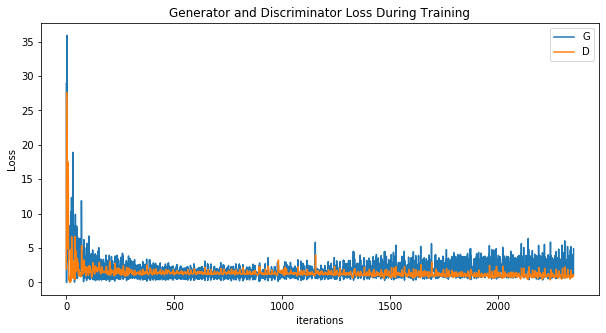

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

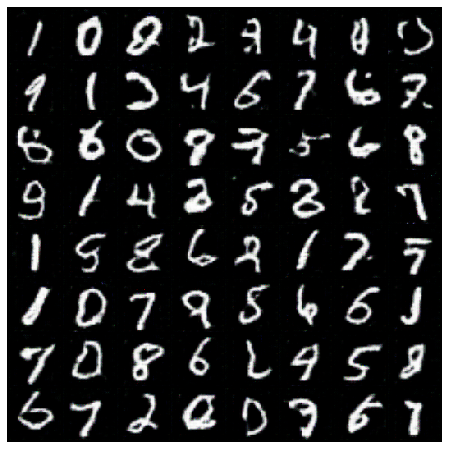

In [12]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

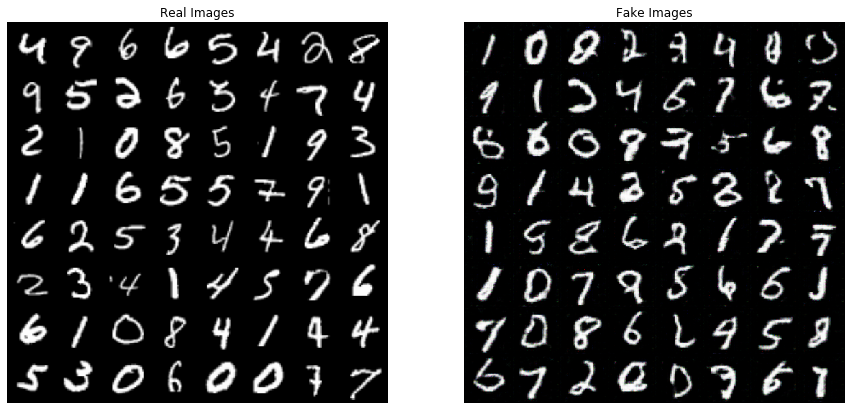

In [11]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()